In [1]:
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import to_categorical
import os
import cv2
from tqdm import tqdm
import random
import pickle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

Using TensorFlow backend.


In [2]:
DATADIR = "/Users/ryanklapper/Desktop/2020/Data Science/search-bing-api/dataset/"

CATEGORIES = ["Bagpipes","Harmonica","Flute","Piano","Saxophone","Guitar",]
training_data = []
IMG_SIZE = 350
def train():
    for category in CATEGORIES:  # iterate each instrument

        path = os.path.join(DATADIR,category)  # create path to different instruments
        class_num = CATEGORIES.index(category)  # get the classification of each instrument

        for img in tqdm(os.listdir(path)):  # iterate over each image in each instrument
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:
                pass
            
train()
# Shuffling data so each instrument is trained without bias
random.shuffle(training_data)

X = []
y = []
for music_features,music_label in training_data:
    X.append(music_features)
    y.append(music_label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y = np.array(y)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=13)
input_shape = (IMG_SIZE, IMG_SIZE, 1)

# Prepare the training images
X_train = X_train.reshape(X_train.shape[0], IMG_SIZE, IMG_SIZE, 1)
X_train = X_train.astype('float32')
X_train /= 255

# Prepare the validation images
X_val = X_val.reshape(X_val.shape[0], IMG_SIZE, IMG_SIZE, 1)
X_val = X_val.astype('float32')
X_val /= 255

100%|██████████| 201/201 [00:04<00:00, 48.49it/s]


In [3]:
DATADIR_TEST = "/Users/ryanklapper/Desktop/2020/Data Science/images"
testing_data = []
def test():
    for img in tqdm(os.listdir(DATADIR_TEST)): # iterate over each image in ISS Dataset
        try:
            img_test_array = cv2.imread(os.path.join(DATADIR_TEST,img) ,cv2.IMREAD_GRAYSCALE) # convert to array
            new_test_array = cv2.resize(img_test_array, (IMG_SIZE, IMG_SIZE)) # resize to normalize data size
            testing_data.append([new_test_array])
        except Exception as e:
            pass
test()

# Shuffling data so each image is trained without bias
random.shuffle(testing_data)
X_Test = []

# Adding each ISS image to X_Test
for iss_images in testing_data:
    X_Test.append(iss_images)

X_Test = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

100%|██████████| 7294/7294 [05:53<00:00, 20.66it/s]


In [4]:
# Creating name of tensorboard
NAME = "Is-Music-Relevant-CNN"

X = X/255.0

# Rotating the images for better training
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                               height_shift_range=0.08, zoom_range=0.08)
batches = gen.flow(X, y, batch_size=32)
val_batches = gen.flow(X_val, y_val, batch_size=32)

# Creation of the model
model = Sequential()
# Layers of the model
model.add(Conv2D(30, (3, 3), input_shape=X.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(30, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(6))
model.add(Activation("sigmoid"))

# Creation of tensorboard to look at statistics
tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))
# Compiling the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# Generating summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 348, 348, 30)      300       
_________________________________________________________________
activation (Activation)      (None, 348, 348, 30)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 174, 174, 30)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 172, 172, 30)      8130      
_________________________________________________________________
activation_1 (Activation)    (None, 172, 172, 30)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 86, 86, 30)        0         
_________________________________________________________________
flatten (Flatten)            (None, 221880)            0

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 35 steps, validate for 0.3 steps
Epoch 1/4
35/35 [==============================] - 45s 1s/step - loss: 0.1183 - accuracy: 0.9604 - val_loss: 0.2965 - val_accuracy: 0.9688
Epoch 2/4
35/35 [==============================] - 45s 1s/step - loss: 0.1183 - accuracy: 0.9559 - val_loss: 0.2946 - val_accuracy: 0.9688
Epoch 3/4
35/35 [==============================] - 43s 1s/step - loss: 0.1182 - accuracy: 0.9595 - val_loss: 0.2443 - val_accuracy: 0.9688
Epoch 4/4
35/35 [==============================] - 43s 1s/step - loss: 0.1187 - accuracy: 0.9595 - val_loss: 0.4257 - val_accuracy: 0.9688
Test loss: 0.1454662050944301
Test accuracy: 0.94925636


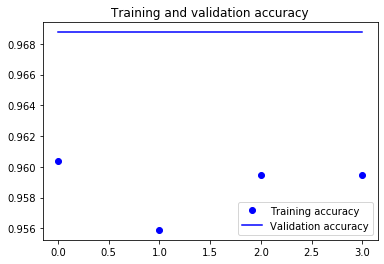

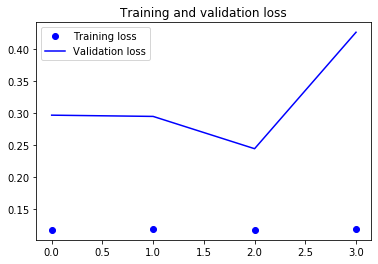

              precision    recall  f1-score   support

     Class 0       0.96      0.96      0.96       184
     Class 1       0.99      0.92      0.95       189
     Class 2       1.00      0.82      0.90       189
     Class 3       0.94      1.00      0.97       195
     Class 4       0.85      1.00      0.92       186
     Class 5       0.98      0.99      0.99       200

    accuracy                           0.95      1143
   macro avg       0.95      0.95      0.95      1143
weighted avg       0.95      0.95      0.95      1143

INFO:tensorflow:Assets written to: /Users/ryanklapper/Desktop/2020/Data Science/MachineLearningISS/assets


In [16]:
action = model.fit_generator(batches, steps_per_epoch=len(X)//32, epochs=4,
                    validation_data=val_batches, validation_steps=0.3,callbacks=[tensorboard])
test_statistics = model.evaluate(X, y, verbose=0)
print('Test loss:', test_statistics[0])
print('Test accuracy:', test_statistics[1])
%matplotlib inline

accuracy = action.history['accuracy']
val_accuracy = action.history['val_accuracy']
loss = action.history['loss']
val_loss = action.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

predicted_classes = model.predict_classes(X)
# get the indices to be plotted
y_true = y
correct = np.nonzero(predicted_classes==y_true)[0]
incorrect = np.nonzero(predicted_classes!=y_true)[0]

target_names = ['Class {}'.format(i) for i in range(6)]
print(classification_report(y_true, predicted_classes, target_names=target_names))

# Saving the model
model.save('/Users/ryanklapper/Desktop/2020/Data Science/MachineLearningISS')
# To load the model
# Recreate the exact same model purely from the file:
# model = keras.models.load_model('path_to_my_model.h5')


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 348, 348, 128)     1280      
_________________________________________________________________
activation_15 (Activation)   (None, 348, 348, 128)     0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 174, 174, 128)     0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 172, 172, 128)     147584    
_________________________________________________________________
activation_16 (Activation)   (None, 172, 172, 128)     0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 86, 86, 128)       0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 946688)           

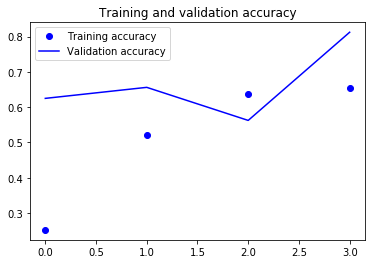

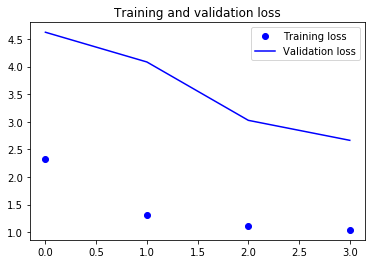

              precision    recall  f1-score   support

     Class 0       0.27      0.72      0.39       184
     Class 1       0.67      0.01      0.02       189
     Class 2       1.00      0.22      0.36       189
     Class 3       0.64      0.97      0.78       195
     Class 4       0.80      0.88      0.84       186
     Class 5       0.98      0.55      0.71       200

    accuracy                           0.56      1143
   macro avg       0.73      0.56      0.51      1143
weighted avg       0.73      0.56      0.52      1143



In [20]:
gen_test = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                               height_shift_range=0.08, zoom_range=0.08)
batches_test = gen.flow(X_Test, y, batch_size=256)
val_batches_test = gen.flow(X_val, y_val, batch_size=256)

model_test = Sequential()
# Layers of the model
model_test.add(Conv2D(128, (3, 3), input_shape=X_Test.shape[1:]))
model_test.add(Activation('relu'))
model_test.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model_test.add(Conv2D(128, (3, 3)))
model_test.add(Activation('relu'))
model_test.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model_test.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_test.add(Dense(6))
model_test.add(Activation("sigmoid"))
model_test.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_test.summary()
action_test = model_test.fit_generator(batches, steps_per_epoch=len(X)//32, epochs=4,
                    validation_data=val_batches, validation_steps=0.3,callbacks=[tensorboard])

test_model_stats = model_test.evaluate(X_Test, y, verbose=0)
print('Test loss:', test_model_stats[0])
print('Test accuracy:', test_model_stats[1])
%matplotlib inline

accuracy = action_test.history['accuracy']
val_accuracy = action_test.history['val_accuracy']
loss = action_test.history['loss']
val_loss = action_test.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

predicted_classes = model.predict_classes(X_Test)
# get the indices to be plotted
y_true = y
correct = np.nonzero(predicted_classes==y_true)[0]
incorrect = np.nonzero(predicted_classes!=y_true)[0]

target_names = ['Class {}'.format(i) for i in range(6)]
print(classification_report(y_true, predicted_classes, target_names=target_names))